In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import random
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetRegressor
%matplotlib inline

In [2]:
args = {
    'noise':0.01,
    'train size':0.7,
    'spec scale':10**12,
    'scaler':RobustScaler(),
    }

param_grid = {
    'optimizer' : [torch.optim.Rprop],
    'optimizer__lr' : [0.01],
    'max_epochs' : [3000]
}

In [3]:
df = pd.read_excel('data_3nm.xlsx')

In [4]:
# spectrum data
X = df.iloc[:,11:]

# layer data
y = df.iloc[:,:11]

In [5]:
# scale by 10^12
X = X.apply(lambda x: x*args['spec scale'])

In [6]:
def add_noise(data, percentage):
    std_dev = percentage
    noise = np.random.normal(0, std_dev, data.shape)
    noisy_data = data + noise
    return noisy_data

In [7]:
# add noise
X_noisy = add_noise(X, args['noise'])

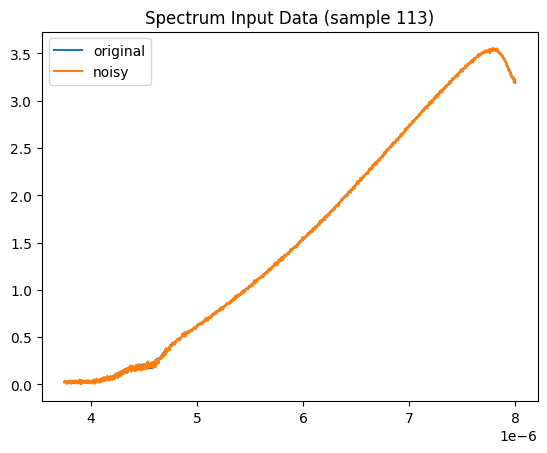

In [8]:
entry = random.randint(0, len(X))
plt.title(f'Spectrum Input Data (sample {entry})')
plt.plot(X.iloc[entry], label='original')
plt.plot(X_noisy.iloc[entry], label='noisy')
plt.legend()
plt.show()

In [9]:
scaler = args['scaler']
scaler.fit(X_noisy)
X_noisy_scaled = scaler.transform(X_noisy)

X_noisy_scaled_df = pd.DataFrame(X_noisy_scaled, columns=X.columns)

In [10]:
X_tensor = torch.tensor(X_noisy_scaled_df.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

In [11]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(input_size, 30)
        self.lin2 = nn.Linear(30, 15)
        self.lin_fin = nn.Linear(15, output_size)

    def forward(self, x):
        x = F.leaky_relu(self.lin1(x))
        x = F.leaky_relu(self.lin2(x))
        x = self.lin_fin(x)
        return x

In [12]:
input_size = len(X.columns)
output_size = len(y.columns)

In [13]:
net = NeuralNetRegressor(
    module=Net,
    module__input_size=input_size,
    module__output_size=output_size,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

gs = GridSearchCV(net, param_grid, scoring='neg_mean_absolute_error', cv=5, verbose=3)

gs.fit(X_tensor, y_tensor)

best_model = gs.best_estimator_
best_params = gs.best_params_

print('Best loss: {}'.format(gs.best_score_))
print('Params: {}'.format(best_params))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    76389.0877    28063.2614  0.1040
      2    27156.2477    19643.2436  0.0884
      3    14890.0701     9964.9747  0.0725
      4     5949.7885     2383.7380  0.0880
      5     1351.7724      559.7004  0.0880
      6      363.1794      267.7873  0.0800
      7      215.8500      203.8489  0.0960
      8      183.2610      180.5945  0.0880
      9      167.3451      169.8168  0.0880
     10      154.7624      159.7387  0.0880
     11      143.9119      147.7734  0.0880
     12      130.8406      135.1454  0.0880
     13      122.0773      128.8002  0.0880
     14      116.9026      125.2242  0.0880
     15      113.0664      121.5458  0.0880
     16      109.8606      117.0830  0.0960
     17      106.9622      113.7528  0.0880
     18      105.2687      112.1830  0.0880
     19      103.7224      110.8678  0.0800
     20      102.

    141       63.5670       66.5949  0.1000
    142       63.5530       66.5835  0.0928
    143       63.5396       66.5720  0.1070
    144       63.5294       66.5631  0.0914
    145       63.5214       66.5550  0.0908
    146       63.5144       66.5474  0.1034
    147       63.5081       66.5401  0.0813
    148       63.5019       66.5328  0.0834
    149       63.4958       66.5257  0.0886
    150       63.4893       66.5184  0.0834
    151       63.4830       66.5114  0.0827
    152       63.4768       66.5048  0.0860
    153       63.4704       66.4983  0.0763
